In [ ]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

import streamlit as st
import joblib


In [ ]:
# Load interest rate data

df_interest = pd.read_csv("interest_rates.csv")

# Data cleaning

df_interest["Date"] = pd.to_datetime(df_interest["Date Changed"], errors="coerce")
df_interest = df_interest.dropna(subset=["Date"])
df_interest["Year"] = df_interest["Date"].dt.year

df_interest.rename(columns={"Rate": "Interest Rate"}, inplace=True)

df_interest = df_interest.dropna(subset=["Interest Rate"])
df_interest["Interest Rate"] = pd.to_numeric(df_interest["Interest Rate"], errors="coerce")

df_interest_yearly = df_interest.groupby("Year")["Interest Rate"].mean().reset_index()



C:\Users\ahmed\AppData\Local\Temp\ipykernel_8368\1076345154.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_interest["Date"] = pd.to_datetime(df_interest["Date Changed"], errors="coerce")


In [ ]:
# Define column names

columns = [
    "TransactionID", "Price", "Date of Transfer", "Postcode", "Property Type", "Old/New",
    "Duration", "PAON", "SAON", "Street", "Locality", "Town/City", "District", "County",
    "Category Type", "Record Status"
]

chunksize = 100000
london_chunks = []

# Load in chunks and filter for Greater London

for chunk in pd.read_csv("pp-complete.csv", names=columns, header=None, chunksize=chunksize, low_memory=False):
    # Keep rows where 'Town/City' is London or 'County' is Greater London
    london_only = chunk[
        chunk["Town/City"].str.upper().str.contains("LONDON", na=False) |
        chunk["County"].str.upper().str.contains("LONDON", na=False) |
        chunk["District"].str.upper().str.contains("LONDON", na=False)
    ]
    london_chunks.append(london_only)

# Combine filtered chunks

df_prices = pd.concat(london_chunks, ignore_index=True)

# Clean and prepare

df_prices["Date of Transfer"] = pd.to_datetime(df_prices["Date of Transfer"], errors="coerce")
df_prices = df_prices.dropna(subset=["Date of Transfer"])
df_prices["Year"] = df_prices["Date of Transfer"].dt.year
df_prices = df_prices[["Year", "Price"]]
df_prices_yearly = df_prices.groupby("Year")["Price"].median().reset_index()


In [ ]:
# More cleaning

df_merged = pd.merge(df_prices_yearly, df_interest_yearly, on="Year", how="inner")
print(df_merged.head())

# Save the cleaned + merged data

df_merged.to_csv("merged_property_interest_data.csv", index=False)
print("✅ File saved as 'merged_property_interest_data.csv'")



   Year     Price  Interest Rate
0  1995   72995.0       6.505000
1  1996   77000.0       5.925000
2  1997   86000.0       6.750000
3  1998   96750.0       6.937500
4  1999  118000.0       5.416667
✅ File saved as 'merged_property_interest_data.csv'


In [ ]:
# Check overlapping years

print("📅 Property Data Years:", df_prices_yearly["Year"].min(), "-", df_prices_yearly["Year"].max())
print("📅 Interest Rate Years:", df_interest_yearly["Year"].min(), "-", df_interest_yearly["Year"].max())

print("🏘 Property Data:\n", df_prices_yearly["Year"].unique())
print("💰 Interest Rate Data:\n", df_interest_yearly["Year"].unique())



📅 Property Data Years: 1995 - 2025
📅 Interest Rate Years: 1975 - 2025
🏘 Property Data:
 [1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022
 2023 2024 2025]
💰 Interest Rate Data:
 [1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2003
 2004 2005 2006 2007 2008 2009 2016 2017 2018 2020 2021 2022 2023 2024
 2025]


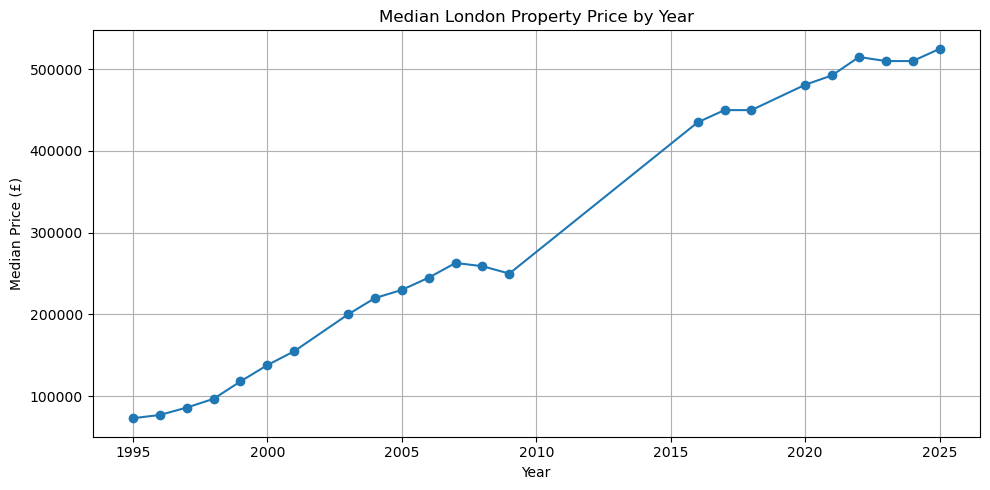

In [ ]:
# Visualisation 1: Median London Property Price Over Time 

plt.figure(figsize=(10, 5))
plt.plot(df_merged["Year"], df_merged["Price"], marker='o')
plt.title("Median London Property Price by Year")
plt.xlabel("Year")
plt.ylabel("Median Price (£)")
plt.grid(True)
plt.tight_layout()
plt.show()

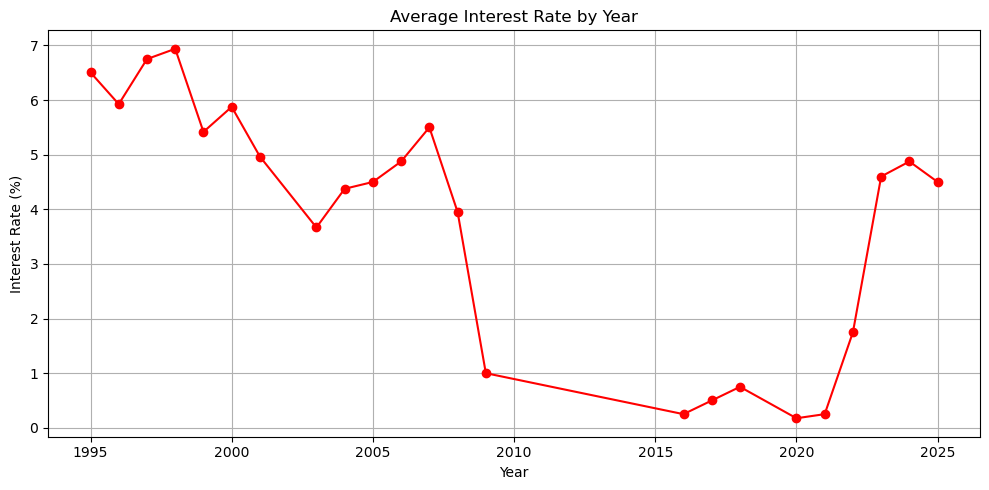

In [ ]:
# Visualisation 2: Average Interest Rate Over Time

plt.figure(figsize=(10, 5))
plt.plot(df_merged["Year"], df_merged["Interest Rate"], marker='o', color='red')
plt.title("Average Interest Rate by Year")
plt.xlabel("Year")
plt.ylabel("Interest Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

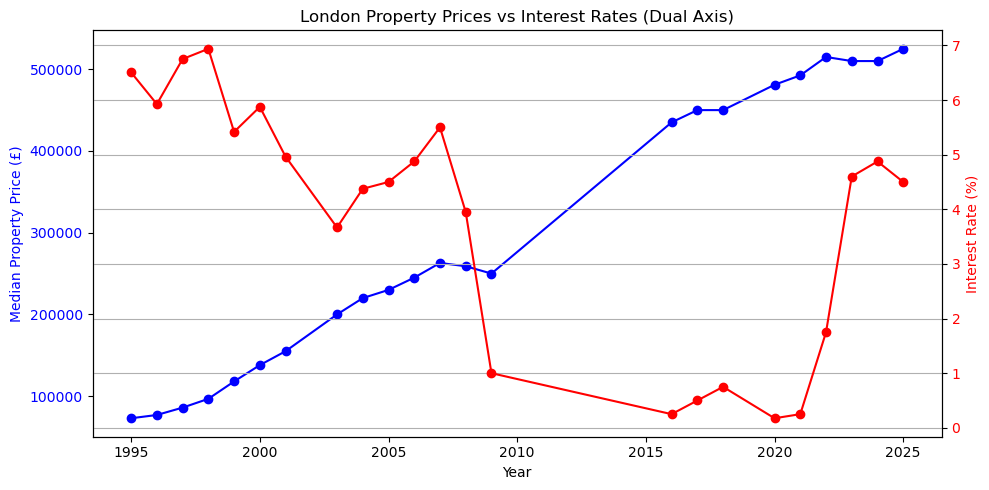

In [ ]:
# Visualisation 3: Prices vs Interest rate

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot property prices (left y-axis)

ax1.plot(df_merged["Year"], df_merged["Price"], color='blue', marker='o')
ax1.set_xlabel("Year")
ax1.set_ylabel("Median Property Price (£)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis

ax2 = ax1.twinx()
ax2.plot(df_merged["Year"], df_merged["Interest Rate"], color='red', marker='o')
ax2.set_ylabel("Interest Rate (%)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("London Property Prices vs Interest Rates (Dual Axis)")
plt.grid(True)
plt.tight_layout()
plt.show()




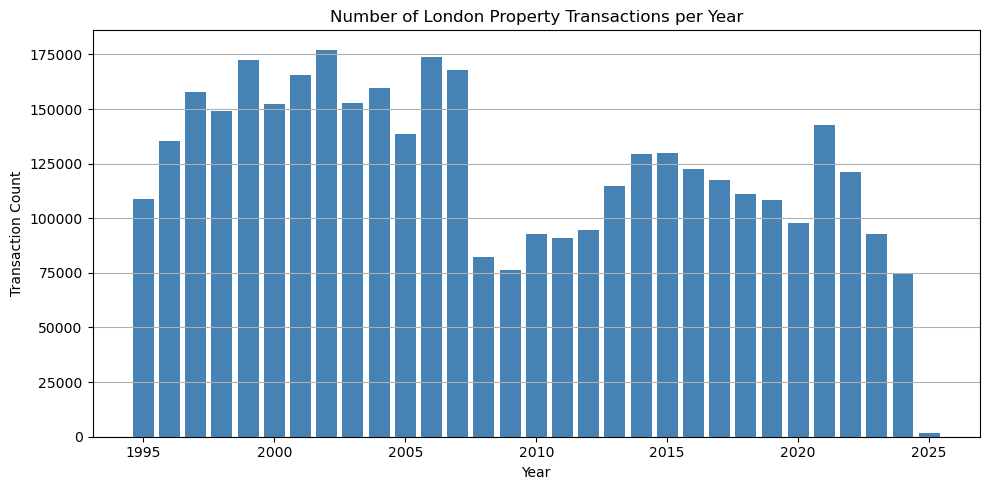

In [ ]:
# Visualisation 4: Count of property records per year

year_counts = df_prices["Year"].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(year_counts.index, year_counts.values, color='steelblue')
plt.title("Number of London Property Transactions per Year")
plt.xlabel("Year")
plt.ylabel("Transaction Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

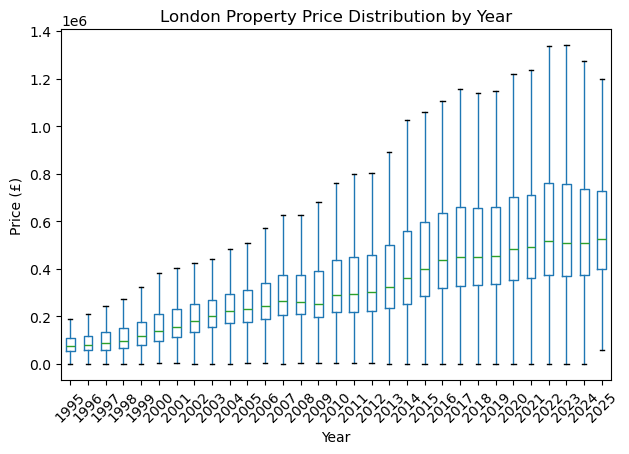

In [ ]:
# Visualisation 5: Prices per Year

plt.figure(figsize=(12, 6))
df_prices.boxplot(column="Price", by="Year", grid=False, showfliers=False)
plt.title("London Property Price Distribution by Year")
plt.suptitle("")  
plt.xlabel("Year")
plt.ylabel("Price (£)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Correlation matrix

correlation_matrix = df_merged[["Price", "Interest Rate"]].corr()
print("📊 Correlation Matrix:")
print(correlation_matrix)


📊 Correlation Matrix:
                 Price  Interest Rate
Price          1.00000       -0.69479
Interest Rate -0.69479        1.00000


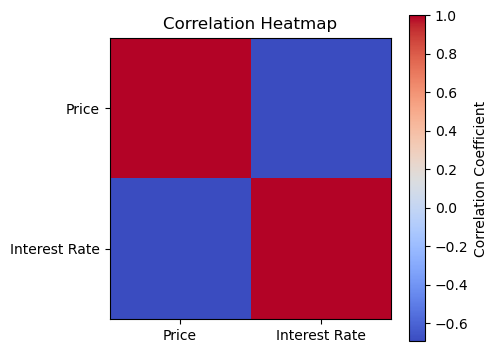

In [ ]:
# Heatmap using matplotlib

plt.figure(figsize=(5, 4))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label="Correlation Coefficient")
plt.xticks([0, 1], correlation_matrix.columns)
plt.yticks([0, 1], correlation_matrix.index)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


📊 Linear Regression Performance:
R² Score: 0.867
Mean Absolute Error: 43283.38
Mean Squared Error: 3127453368.04
----------------------------------------
📊 Decision Tree Performance:
R² Score: -0.536
Mean Absolute Error: 128801.0
Mean Squared Error: 36141151005.0
----------------------------------------


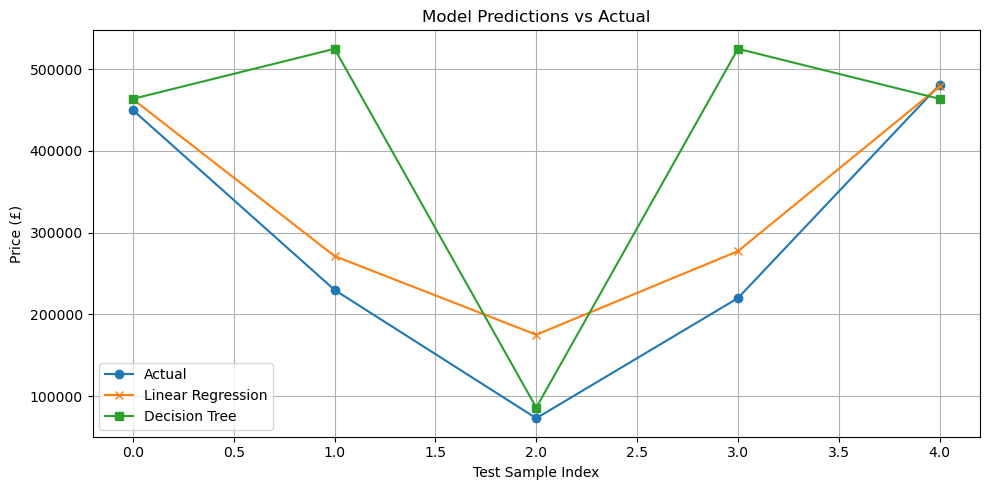

In [ ]:

# Prepare features and target 

X = df_merged[["Interest Rate"]]
y = df_merged["Price"]

# Split into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression 

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

def evaluate(model_name, y_true, y_pred):
    print(f"📊 {model_name} Performance:")
    print("R² Score:", round(r2_score(y_true, y_pred), 3))
    print("Mean Absolute Error:", round(mean_absolute_error(y_true, y_pred), 2))
    print("Mean Squared Error:", round(mean_squared_error(y_true, y_pred), 2))
    print("-" * 40)

evaluate("Linear Regression", y_test, lr_preds)
evaluate("Decision Tree", y_test, dt_preds)

plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual", marker='o')
plt.plot(lr_preds, label="Linear Regression", marker='x')
plt.plot(dt_preds, label="Decision Tree", marker='s')
plt.title("Model Predictions vs Actual")
plt.xlabel("Test Sample Index")
plt.ylabel("Price (£)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

# Load merged dataset

df = pd.read_csv("merged_property_interest_data.csv")

X = df[["Interest Rate"]]
y = df["Price"]


st.write("🔍 Loaded Data Sample:")
st.dataframe(df.head())
st.write("📏 Dataset Shape:", df.shape)


model = LinearRegression()
model.fit(X, y)

# Create Streamlit App

st.set_page_config(page_title="London Price Predictor", layout="centered")

st.title("🏠 London Property Price Predictor")
st.write("This app estimates the median London property price based on interest rate.")

# Interest Rate Input

interest = st.slider("Select Interest Rate (%)", min_value=0.0, max_value=10.0, step=0.1)

# Predict Button

if st.button("Predict"):
    prediction = model.predict([[interest]])[0]
    formatted_price = f"£{int(prediction):,}"
    st.success(f"Estimated Median Property Price: {formatted_price}")


2025-03-28 05:16:22.377 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-28 05:16:22.377 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-28 05:16:22.377 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-28 05:16:22.377 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-28 05:16:22.387 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-28 05:16:22.387 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-28 05:16:22.387 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-28 05:16:22.387 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar